<a href="https://colab.research.google.com/github/GuilleMarc/CROWN/blob/master/Geopilot_analytics_venus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#####################################################################################################################
############################# Run the block cells below to get the environment ready ###############################
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth,drive
from oauth2client.client import GoogleCredentials

In [0]:
# Will ask you an authorization code; copy and paste it
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
os.chdir('/gdrive')
os.chdir('My Drive/Geoinformatics Pilot/Geoinformatics Pilot PUBLIC/Venus_preprocessed_Data')
print('Current directory is: {}'.format(os.getcwd()))

Current directory is: /gdrive/My Drive/Geoinformatics Pilot/Geoinformatics Pilot PUBLIC/Venus_preprocessed_Data


In [0]:
#!ls # Files needed to run this notebook are: Sampled_Venus_L2A_clean.csv, Original_biomass_BARC.csv
#########################################################################################################################
###########################################################################################################################

# Geoinformatics ESRI-USDA Pilot Project --- Cover Crops

Analytics workflow for the reflectance data from Venus imagery (11 bands, 30 m. resolution) analyzed for rye and wheat fields at the BARC station, and obtained at different dates in fall-spring (2018-2019). Additionally, selected rye and wheat fields were sampled for biomass at a single date (April 30, 2019). 

- **Could we use a selection of vegetative indices in advance to characterize rye biomass?**
- **Could we use mean and variance of selected indices to define areas of high/low productivity and stability?**

**<<Data sources, collaborators (TODO)>>**


In [0]:
!ls

'Cover Crop Geoinformatics Pilot 2019-NDRE imagery.7z'
'Cover Crop Geoinformatics Pilot 2019-NDVI-imagery.7z'
 Geopilot_analytics_venus.ipynb
 NDVI_Composite.tif
 Original_biomass_BARC.csv
 PILOT_project_biomass_with_venus.csv
 PILOT_project_biomass_with_venus.gsheet
'RedEdge NDVI_Composite.tif'
 Sampled_Venus_L2A_clean.csv
 Sampled_Venus_L2A_nick.csv
 Sampled_Venus_L2A_nick.gsheet
'tractor_data_with_venus_bands Apr 30.csv'
 tractor_data_with_venus_ndvi.csv
 Veg_BARC.xlsx
'Venus L2 Map - NDVI.mp4'


# Load up libraries and datasets:

In [0]:
# Loading up libraries:
import os
import warnings
import datetime
import numpy as np, pandas as pd, scipy
import matplotlib.pyplot as plt, seaborn as sns

# Import datasets:
refl= pd.read_csv("Sampled_Venus_L2A_clean.csv") #reflectance at different times (~images)
bmass= pd.read_csv("Original_biomass_BARC.csv") #biomass at one time

# Cleaning data

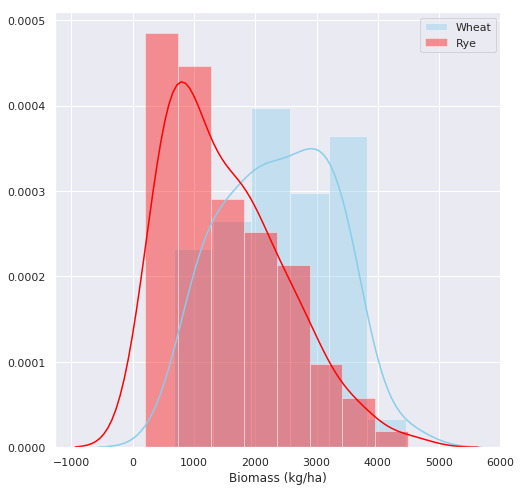

In [0]:
# ------------------- BIOMASS -----------------------------------#
# Which obs is missing from biomass:
missing_biomass= bmass[bmass.isna().any(axis=1)] # missing point is obs 4 (Wheat, field 1_13,OBJECTID 5)

# Drop the missing point:
bmass= bmass.dropna()

# Removing bad data:
bmass= bmass[bmass["Biomass (kg/ha)"] < 6000] # --- two biomass ouliers messing up the analysis

# Check if biomass is within reasonable limits

plt.figure(figsize=(8,8))
sns.distplot(bmass[bmass["Cover crop"].isin(["Wheat"])]["Biomass (kg/ha)"], color="skyblue", label="Wheat")
sns.distplot(bmass[bmass["Cover crop"].isin(["Rye"])]["Biomass (kg/ha)"], color="red", label="Rye")
plt.legend()
plt.show()

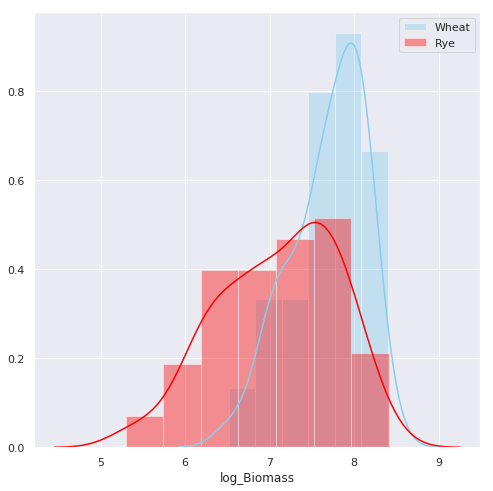

In [0]:
# Apply a log-transformation on biomass (Rye is pretty left-skewed. Wheat is very normal(transf won't change it))

bmass["log_Biomass"]= np.log(bmass["Biomass (kg/ha)"]) # Create another column to avoid confusion later

# Run histogram again
plt.figure(figsize=(8,8))
sns.distplot(bmass[bmass["Cover crop"].isin(["Wheat"])]["log_Biomass"], color="skyblue", label="Wheat")
sns.distplot(bmass[bmass["Cover crop"].isin(["Rye"])]["log_Biomass"], color="red", label="Rye")
plt.legend()
plt.show()

#Biomass good to go

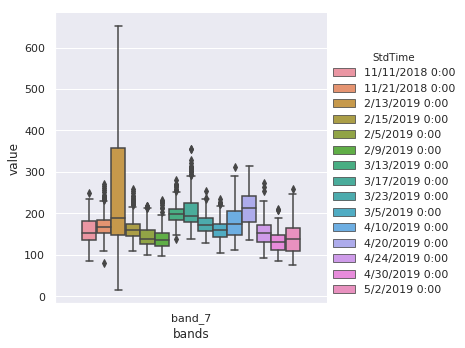

In [0]:
# ----------------- Reflectance----------------------------

# Several columns are useless, drop them.e.g VE_VM01_VSC_PDTIMG_L2VALD_BA_2
to_drop= ['VE_VM01_VSC_PDTIMG_L2VALD_BA_2','Variable', 'Dimensions','StdTime_1']
to_keep= [column for column in refl.columns if column not in to_drop]  ## Could work also: refl.drop(to_drop, axis=1)
refl= refl.loc[:,to_keep]

# Check the quality of the inputs: Are the distributions looking OK?
refl_bands=[variable for variable in to_keep if "Venus" in variable ]
band_checks= refl.loc[:,refl_bands+["StdTime"]].rename(columns={"Venus_BARC_L2A_{}".format(n): "band_{}".format(n) for n in range(0,12)})
#band_checks= band_checks[band_checks["StdTime"] == "3/17/2019 0:00"]# --- turn this on if want it by date
#plt.figure(figsize=(10,8))
sns.catplot(x= "bands",
            y= "value",
            hue="StdTime",
            data= band_checks.melt( id_vars=["StdTime"], 
                                    value_vars=["band_7"],
                                    var_name= "bands", 
                                    value_name= "value",
                                    ).sort_values(by="StdTime"),
            kind="box",
           )
plt.show()

In [0]:
# There were suspicious anomalies in three dates:
bad_dates= ["2/13/2019 0:00","4/20/2019 0:00","3/5/2019 0:00"]

# retain only "good dates"
refl= refl[~refl["StdTime"].isin(bad_dates)]

# reflectance good to go!

## Merge the reflectance and biomass data

In [0]:
# identify primary keys in both dfs --  where to Merge on 
bmass.head(3)
print(10 * "---","biomass dataset", 10 * "---")
print(bmass["OBJECTID"].unique())
print(10 * "---","Venus dataset", 10 * "---")
print(refl["L02019_PILOT_project_biomass"].unique())
# Looks good

------------------------------ biomass dataset ------------------------------
[  1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147]
------------------------------ Venus dataset ------------------------------
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  

In [0]:
# Pick data needed:
bm= bmass[['OBJECTID','Field_no','Field_id','Cover crop','Zadoks_growth_stage','Biomass (kg/ha)','log_Biomass']]

# Function to merge biomass and reflectance datasets by date of imagery available:
def data_process(bm, refl, sampling_date="3/23/2019 0:00"):
    '''
    Computes a set of vegetative indexes based on biomass observed data
    and Raw reflectance (11 bands) covering visible to NIR ranges from Venus.
    inputs: band_1 ... band_11, biomass (kg.ha)
    output: a pd.DataFrame with site and crop features plus vegetative indices
    parameter: The only parameter to adjust is sampling date
    '''
    # Filter biomass obs. for the date picked, and avoid duplicates
    rfl= refl[ refl["StdTime"] == sampling_date].drop(["OBJECTID"],axis=1)
    rfl= (pd.concat(
            [
                rfl[['StdTime','L02019_PILOT_project_biomass']],
                rfl.filter(regex= "^Venus_BARC_L2A_"),
            ],
          axis=1
         ).rename(
                   columns={
                             'L02019_PILOT_project_biomass':'OBJECTID'
                           }
                 )
        )
    data_out= (pd.merge(
                        bm,
                        rfl,
                        how= "inner",
                        on= "OBJECTID"
                        ).rename(
                                 columns={
                                           'Venus_BARC_L2A_{}'.format(n):'Band_{}'.format(n) for n in range(0,12)
                                         }
                                ).assign(
                                          NDVI= lambda x: (x['Band_11']-x['Band_7'])/(x['Band_11']+x['Band_7']),
                                          NDVIRE= lambda x: (x['Band_11']-x['Band_8'])/(x['Band_11']+x['Band_8']),
                                          NDGVI= lambda x: (x['Band_11']-x['Band_4'])/(x['Band_11']+x['Band_4']),
                                          NGRDI= lambda x: np.abs((x['Band_4']-x['Band_7'])/(x['Band_4']+x['Band_7'])),
                                          CLGI= lambda x: (x['Band_11']/x['Band_4'] - 1),
                                          VARI= lambda x: (x['Band_4']-x['Band_7'])/(x['Band_4']+x['Band_7']+x['Band_3']),
                                          SR= lambda x: (x['Band_11']/x['Band_7']),
                                          GRD= lambda x: (x['Band_4']-x['Band_7']),
                                          SAVI= lambda x: (((x['Band_11']- x['Band_7'])/(x['Band_11']+x['Band_7']+0.5)) * (1+0.5)),
                                          RTVI= lambda x: (100*(x['Band_11']-x['Band_8']) - 10*(x['Band_11']-x['Band_4']))      
                                         )
        
              )
    data_out["StdTime"]= pd.to_datetime(data_out["StdTime"]).dt.to_period("D")
    return data_out

In [0]:
# ----------------------- Final dataset to work with ----------------------------------------------
# Loop over sampling dates and stack the returned dataframes by date 
sampling_dates= refl.StdTime.unique()
frames= [data_process(bm, refl, sampling_date=date) for date in sampling_dates]
full_dataset= pd.concat(frames)

In [0]:
print("\nDates for analysis, Images",full_dataset.StdTime.unique())
print(20 * "---")
print("Final variables for analysis",full_dataset.columns)


Dates for analysis, Images <PeriodArray>
['2019-04-30', '2019-02-09', '2018-11-21', '2019-03-17', '2019-02-05',
 '2019-02-15', '2019-03-23', '2018-11-11', '2019-04-24', '2019-03-13',
 '2019-04-10', '2019-05-02']
Length: 12, dtype: period[D]
------------------------------------------------------------
Final variables for analysis Index(['OBJECTID', 'Field_no', 'Field_id', 'Cover crop', 'Zadoks_growth_stage',
       'Biomass (kg/ha)', 'log_Biomass', 'StdTime', 'Band_0', 'Band_1',
       'Band_2', 'Band_3', 'Band_4', 'Band_5', 'Band_6', 'Band_7', 'Band_8',
       'Band_9', 'Band_10', 'Band_11', 'NDVI', 'NDVIRE', 'NDGVI', 'NGRDI',
       'CLGI', 'VARI', 'SR', 'GRD', 'SAVI', 'RTVI'],
      dtype='object')


## Preliminary results

### How the correlation between indices and biomass change

In [0]:
#1) Analyze the evolution of the correlation between biomass and vegetative indices:

# all indices: ['NDVI', 'NDVIRE', 'NDGVI', 'NGRDI','CLGI', 'VARI', 'SR', 'GRD', 'SAVI', 'RTVI']
# good, so:so, bad= ["NDVI","NDGVI","NGRDI","GRD"]

def corr_date(full_dataset, date="11/11/2018", output="Biomass (kg/ha)"):
    '''
    Computes pearson correlation between indices and biomass
    parameters= date, output wanted (Biomass or log-biomass)
    returns= the biomass-row of the corr. matrix INDICES x BIOMASS (each cell is rj(biomass,index-j))
    '''
    data= full_dataset
    data= data[data["StdTime"] == date]
    corr_data= data.loc[:, ["NDVI","NDGVI","NGRDI","GRD",output]].corr()
    return pd.DataFrame({"{}".format(date): corr_data.loc[output,:]})

In [0]:
# Prepapring datasets:
#corr_date(for all sampling dates)
#modify output in the list-comprehension below if want biomass or log-biomass

corr_dates_frames= [corr_date(full_dataset,date,output="Biomass (kg/ha)") for date in full_dataset["StdTime"].unique()]
corr_dates_ts= pd.concat(corr_dates_frames,axis=1) # concatenate df's into one

# Plot evolution of indices over time
index_time= corr_dates_ts.transpose().sort_index()        #flip indices and columns
index_time= index_time.filter(index_time.columns[:-1])
index_time["date"]= pd.DatetimeIndex(index_time.index)

index_time_long= index_time.melt(
    id_vars= ["date"],
    value_vars= index_time.columns[:-1],
    var_name= "Index",
    value_name='r, (Correlation Biomass, Veg.Index)',
    col_level=None,
)

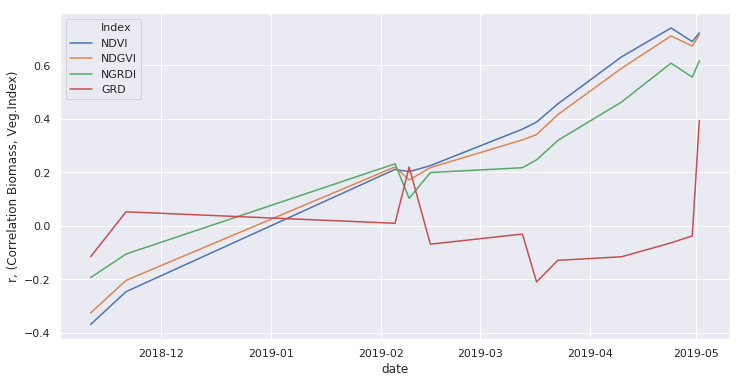

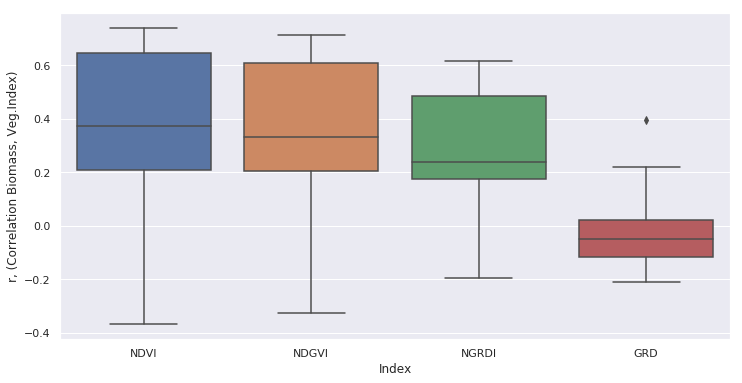

In [0]:
##### ----------------------Plots of interest----------------------------------------------
# A) Correlation index x biomass at different dates
sns.set()
plt.figure(figsize=(12,6))
ts_plot= sns.lineplot(x="date", y="r, (Correlation Biomass, Veg.Index)",
                      hue="Index",
                      err_style='band',
                      data= index_time_long)
plt.show(ts_plot)

# B) Time-variation of vegetative indices (e.g.index avraged over image-dates)
plt.figure(figsize=(12,6))
bx_plot= sns.boxplot(x="Index",
                     y="r, (Correlation Biomass, Veg.Index)",
                     whis=1.75,
                     data= index_time_long,
                    orient="v")
plt.show(bx_plot)

### Pick the best date and analyze the correlation between indices and biomass

The closer a date-image is available for the biomass sampling date, the higher the correlation is. So for April, 30 a correlation map looks like this

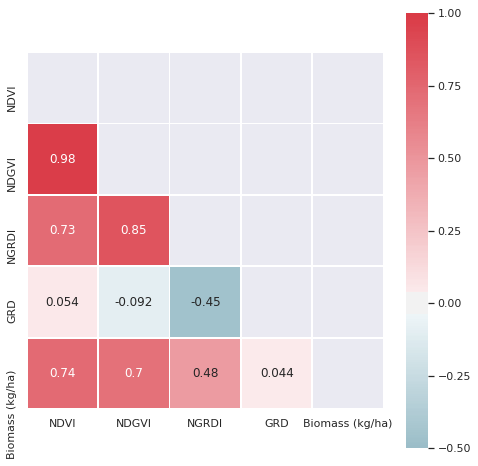

In [0]:
# 1) Which indices are the most correlated with biomass (, and which are the least correlated among them)

# Biomass:Biomass (kg/ha), log: log_Biomass
corr_data= full_dataset[(full_dataset["StdTime"] == "04/30/2019") & (full_dataset["Cover crop"] == "Rye") ] # Change crop and date if want per species 
corr_data= corr_data.loc[:,["NDVI","NDGVI","NGRDI","GRD",'Biomass (kg/ha)']].corr() # change log or biomass if needed

# Create a mask to hide the upper triangle in the heatmap:
mask= np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

#set up the matplotlib fig
f, ax= plt.subplots(figsize=(8,8))

# Generate a color map
cmap= sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask
sns.set()
sns.heatmap(corr_data, mask=mask, cmap=cmap, vmin=-0.5,vmax=1.0,center=0,
            square=True, linewidths=0.85, annot=True)
sns.set(font_scale=0.83)
plt.show()

## Model biomass as a function of indices

Plots below are shown for a good predictor (NDGVI), a poorer predictors just for reference (NGRDI and GRD). Final curve fitting to be done using the good predictor.
The saturation point seems to appear between 2000 and 3000 Kg.ha, as most field studies have shown.

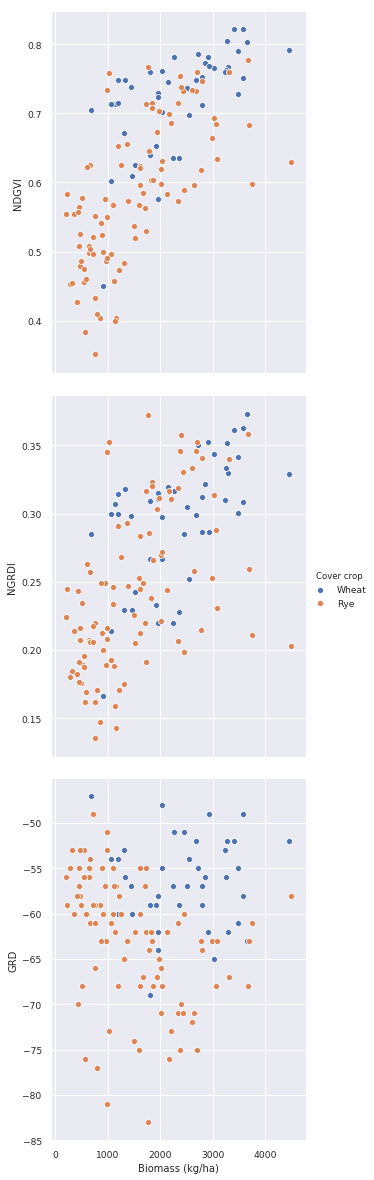

In [0]:

#outputs= 'Biomass (kg/ha)', 'log_Biomass'
# all indices: ['NDVI', 'NDVIRE', 'NDGVI', 'NGRDI','CLGI', 'VARI', 'SR', 'GRD', 'SAVI', 'RTVI']
# good, so:so, bad= ["NDVI","NDGVI","NGRDI","GRD"]

pair_data= full_dataset[full_dataset["StdTime"] == "04/24/2019"]
pair_data= pair_data.loc[:,['Cover crop','NDVI', 'NDGVI',"NGRDI","GRD",'Biomass (kg/ha)']]  #change output if needed
pair_data.head()

#plt.figure(figsize=(10,15))
sns.pairplot(pair_data, y_vars=['NDGVI',"NGRDI","GRD"],
             x_vars=['Biomass (kg/ha)'],
             hue="Cover crop",
             height=5.5,
             aspect=.8)
            # kind="reg")
plt.show()

## Extra steps:

## NDVI over time

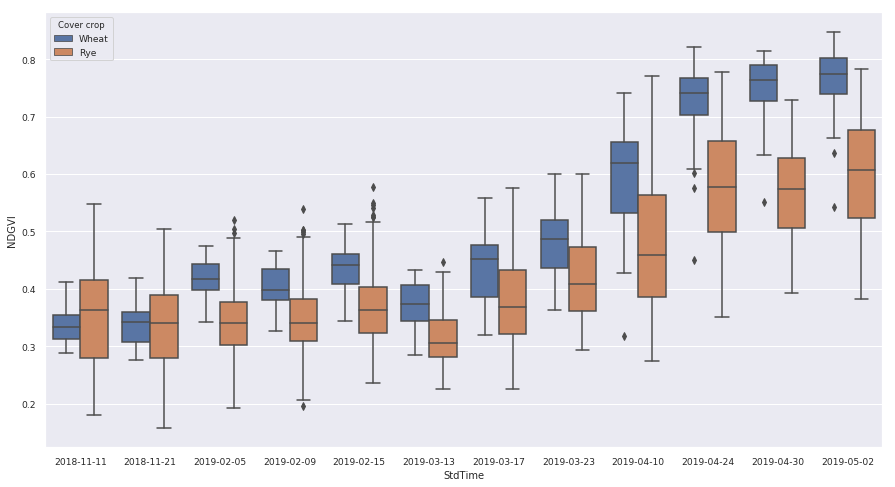

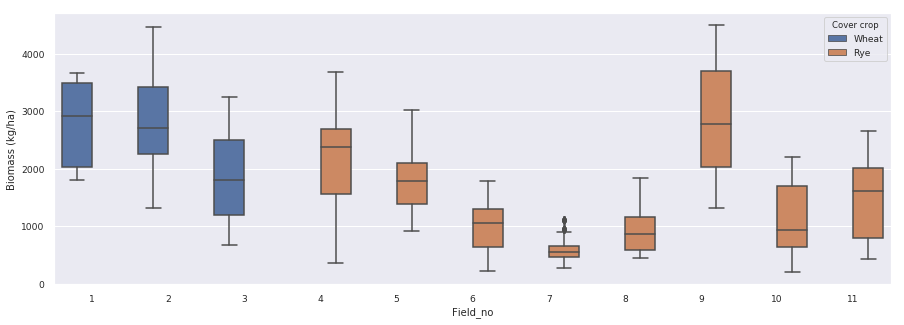

In [0]:
# Whisker plot NDVI over time
# Whisker Biomass over time
plt.figure(figsize=(15,8))
sns.boxplot(x="StdTime",
            y="NDGVI",
            hue="Cover crop",
            data= full_dataset.sort_values(
    by="StdTime",
    axis=0,
    ascending=True,
    inplace=False,
    kind='quicksort',
    na_position='last',
))

# Biomass --- Field variation
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(x="Field_no",
            y="Biomass (kg/ha)",
            hue="Cover crop",
            data= full_dataset.sort_values(
    by="StdTime",
    axis=0,
    ascending=True,
    inplace=False,
    kind='quicksort',
    na_position='last',
))
plt.show()

## How the variability of indices evolve over the season?

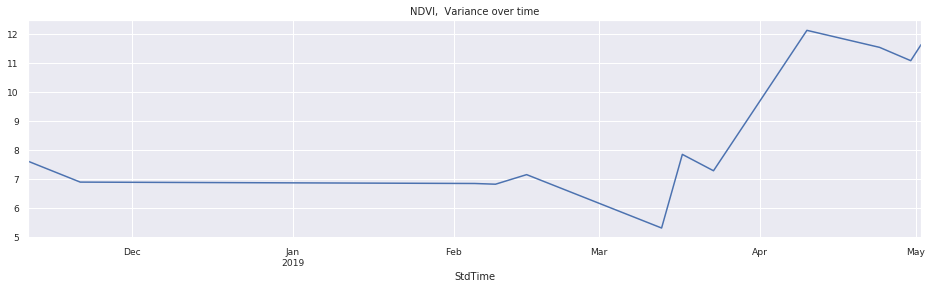

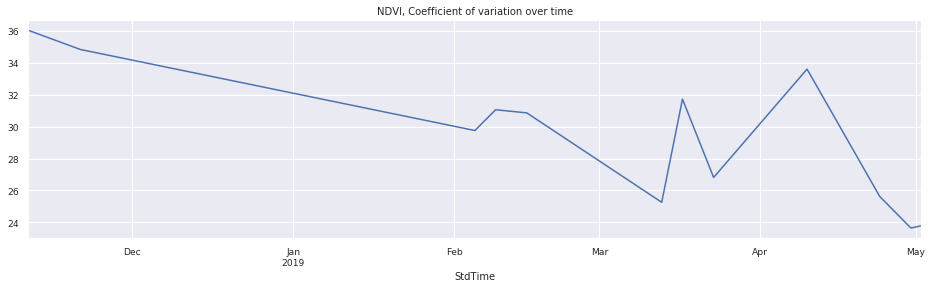

In [0]:
# Variances over time
plt.figure(figsize=(16,4))
(100 * (np.sqrt(full_dataset.groupby(["StdTime"])["NDGVI"].var()))).plot()
plt.title("NDVI,  Variance over time")
plt.show()
plt.figure(figsize=(16,4))
(100 * (np.sqrt(full_dataset.groupby(["StdTime"])["NDGVI"].var())/full_dataset.groupby(["StdTime"])["NDVI"].mean())).plot()
plt.title("NDVI, Coefficient of variation over time")
plt.show()

## Extra: How means and variances relate to each other (Stage 2?)

Could we use such an approach to quickly cluster regions of high biomass/low variance, to low biomass/high variance


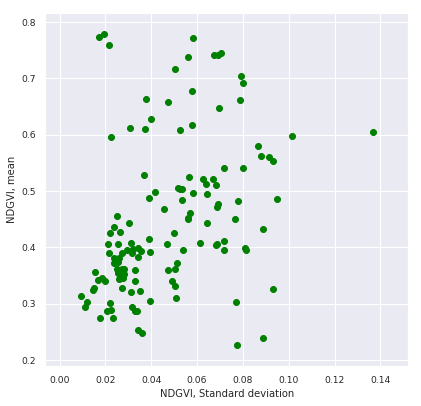

In [0]:
# NDVI Mean vs Variance 
plt.figure(figsize=(6.5,6.5))
plt.scatter(y= full_dataset.groupby(["StdTime","Field_no"])["NDGVI"].mean(),
            x= np.sqrt(full_dataset.groupby(["StdTime","Field_no"])["NDGVI"].var()),
            c="green")
plt.xlabel("NDGVI, Standard deviation")
plt.ylabel("NDGVI, mean")
plt.show()